# Presentation IMA205 Project Cardiac Disease Classification
This notebook presents the work done in an easy and clear way. The idea is that every step developed of the full stack can be presented and explained here.

In [34]:
# Importing the classes
from densenet.densenet import DenseNet
from roi import ROI
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from densnet_trainer import DenseNetTrainer
import random
from niidataloader import NiftiDataset
from feature_extraction_model import FeatureExtractor

ModuleNotFoundError: No module named 'feature_extraction_model'

The whole project has as north the paper: PONER EL NOMBRE DEL PAPER.
This papaer has multiple steps on its pipeline: First extract the Region Of Interest (ROI), this is the subimage where the left ventricle cavity, right vecntricle cavity and myocardium are. The output of the ROI step is a 128x128 image that will be later be segmented. The following code shows how the ROI extractor works.

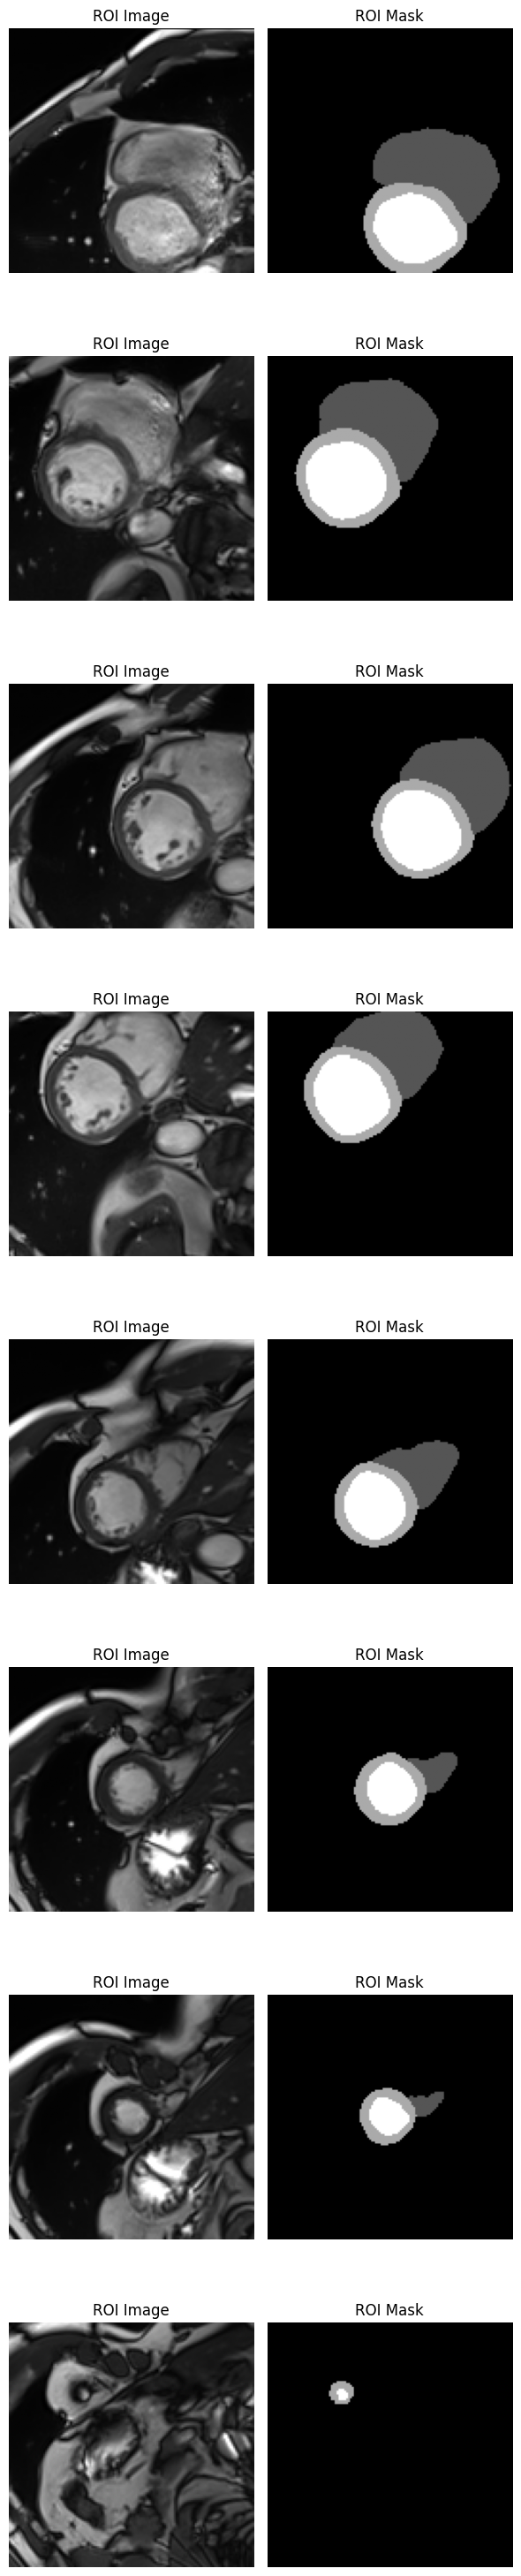

In [2]:
# plot the ROI images
# Load the dataset
roi_extractor = ROI('data/Train')
random.seed(42)
random_int = random.randint(0,100)
roi_image, roi_mask = roi_extractor.get_roi(random_int)

# Create a figure for everty slize in the image
fig, axs = plt.subplots(roi_image.shape[0], 2, figsize=(6, 30))
# Display the image and mask
for index in range(roi_image.shape[0]):
    axs[index, 0].imshow(roi_image[index], cmap='gray')
    axs[index, 1].imshow(roi_mask[index], cmap='gray')
    axs[index, 0].set_title('ROI Image')
    axs[index, 1].set_title('ROI Mask')
    axs[index, 0].axis('off')
    axs[index, 1].axis('off')
plt.tight_layout()
plt.show()



The NiftiDataset is the dataset that I made for this project, it loads the .nii images and returns a (4,220,220,num_slices) tensor. The first 4 correspond to the different images that we have from the same heart, the first one correspond to the end of diastolic phase, the second one to its mask (ground truth), the third one to the end of systolic phase and the last one to its mask.
This dataset have the option to augment the data (with the specifications provided in the paper) and output the ROI for each image (can be augmented as well). All of this was done in order to simplify the training of the densenet.

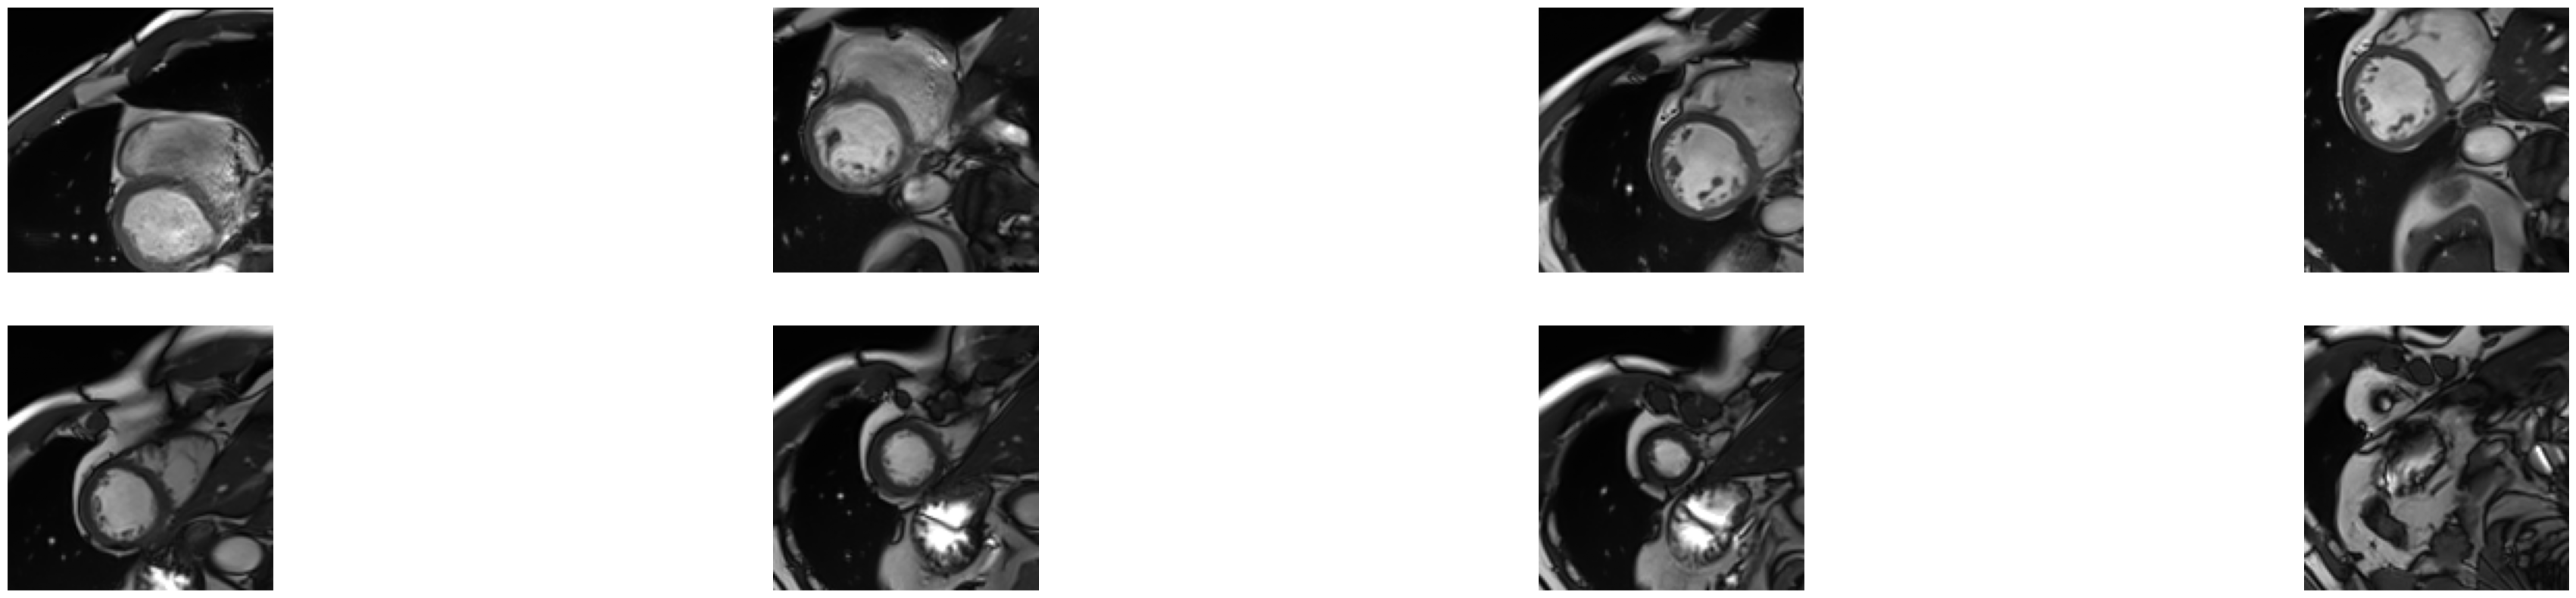

In [15]:
data_path = "./data/Train"
niftiidataset = NiftiDataset(image_path = data_path, roi=True)
diastolic_loaded_image = niftiidataset[random_int][0]
# print(diastolic_loaded_image.shape[-1])
amount_of_slices_over_2=int(roi_image.shape[0]/2)
# print(amount_of_slices_over_2)
fig, axs = plt.subplots(2,amount_of_slices_over_2, figsize=(50, 10))
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx]
    img_idx_2 = int(img_idx%amount_of_slices_over_2)
    am_img=int(img_idx/amount_of_slices_over_2)
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].axis('off')
    axs[am_img,img_idx_2].axis('off')
    # print(img_idx_2, am_img)


After having the image ROI image we will used the densenet described in the paper to segment it, and extract from there the left cavity, right cavity, miocardium and background.
There are two ways of doing this, you can either train the model from the begining or you can use my already trained model, the one that was sent with this work in a .pth file.

In [ ]:
# IF set to true will train the model again. The training took me approximately two hours.
Train_model = False
device = torch.device("cuda")

if Train_model:
    model = DenseNet()
    trainer = DenseNetTrainer(data_path)
    # The trainer configuration is like the one in the article
    trainer = DenseNetTrainer(path_to_images, epochs=200, alpha=0.25, train_fraction=0.8, check_val_every=10)
    trainer.train(model=model)
    model.eval()
else:
    # Load the Model
    model = DenseNet()
    # Load the model weights
    model.load_state_dict(torch.load('/home/onyxia/work/project/CardiacPathologyPrediction/model_weights_best_dice_val0.8000605702400208.pth')["model_state_dict"])
    model.to(device)
    model.eval()

In [32]:
torch.load(('/home/onyxia/work/project/CardiacPathologyPrediction/model_weights_best_dice_val0.8000605702400208.pth'))["epoch"]

50

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


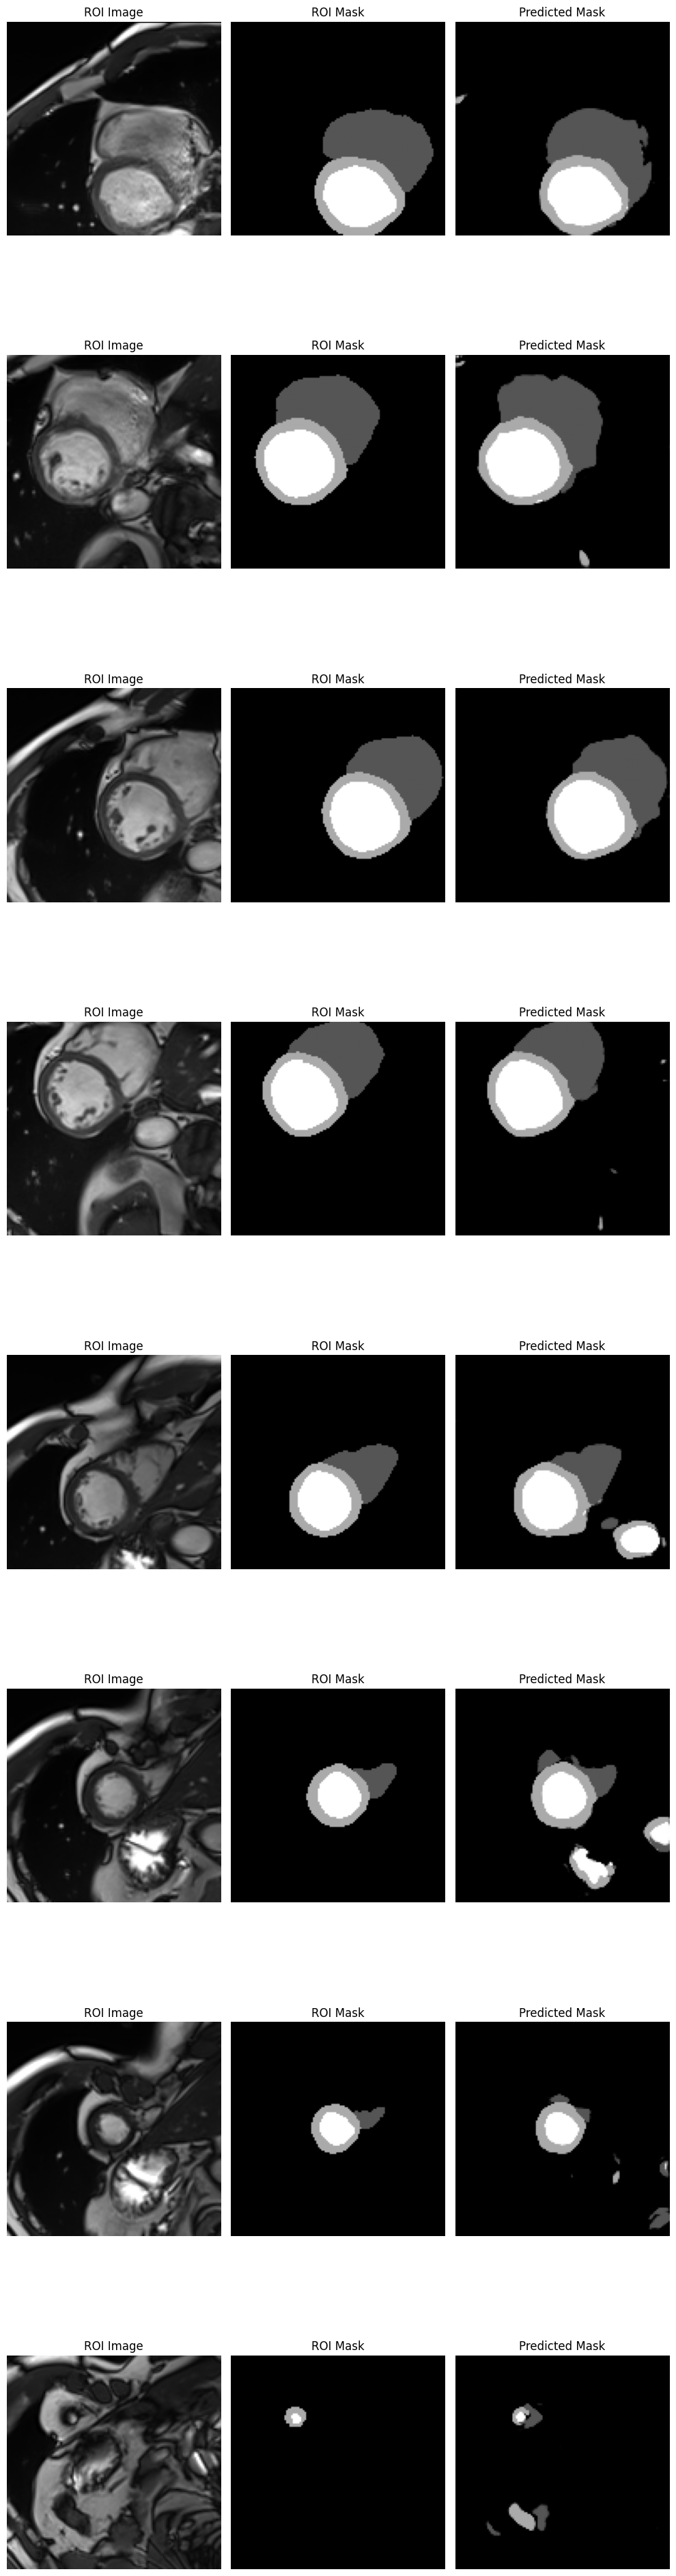

In [30]:
fig, axs = plt.subplots(roi_image.shape[0], 3, figsize=(10, 40))
# Display the image and mask
diastolic_loaded_image_mask = niftiidataset[random_int][1]
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx].to(torch.float32)
    mask = diastolic_loaded_image_mask[:,:,img_idx]
    axs[img_idx, 0].imshow(img, cmap='gray')
    axs[img_idx, 1].imshow(mask, cmap='gray')
    img = img.unsqueeze(0).unsqueeze(0)
    print(img.shape)
    img = img.to(device)
    predicted_mask = model(img).squeeze(0).detach().cpu().numpy()
    pred_mask = 0*predicted_mask[0] + 1*predicted_mask[1] + 2*predicted_mask[2] + 3*predicted_mask[3]
    pred_mask = pred_mask/3
    axs[img_idx, 2].imshow(pred_mask, cmap='gray')
    axs[img_idx, 0].set_title('ROI Image')
    axs[img_idx, 1].set_title('ROI Mask')
    axs[img_idx, 2].set_title('Predicted Mask')
    axs[img_idx, 0].axis('off')
    axs[img_idx, 1].axis('off')
    axs[img_idx, 2].axis('off')
plt.tight_layout()
plt.show()

Now we will use the feature extraction model to extract the features from the 3D the features to use were extracted from the paper: PONER LOS PAPERS DE LAS FEATURES. A random tree is going to be trained after the extraction of the feaures.